In [1]:
# || Header ||
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
import ipywidgets as widgets
from skimage import measure
import linecache
import math
import sys
sys.path.append('/u/home/k/kimvonga/python/')
import sm_fxns as sm
import dimer_dissoc_analysis as lib
import thf_dissoc_analysis as thf_lib
import plot_dimer_diss as plt_lib
import dimer_cavity as cav_lib
import Na2THF_clusters as ntb_fxns
from importlib import reload
plt.rcParams.update({'font.size': 20})

Main purpose is to plot averages while previous notebook "Na2(THF)+_clusters.ipynb" focuses on individual trajectories

Start with molecular geometry and node angle for ensemble. Want to plot against time and bond distance

In [2]:
# to load data for each directory and each time point. use to save time
(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)
bond_dist = np.load('Na2+_THF_cluster/45/bond_dist.npy')
com_dist = np.load('Na2+_THF_cluster/45/com_dist.npy')
coord_num = np.load('Na2+_THF_cluster/45/coord_num.npy')
node_angle = np.load('Na2+_THF_cluster/45/node_angle.npy')
mol_geo = np.load('Na2+_THF_cluster/45/mol_geo.npy')
U_nana = np.load('Na2+_THF_cluster/45/U_nana.npy')
U_nathf = np.load('Na2+_THF_cluster/45/U_nathf.npy')
U_thfthf = np.load('Na2+_THF_cluster/45/U_thfthf.npy')
U_quant = np.load('Na2+_THF_cluster/45/U_quant.npy')

In [3]:
avg_bond_dist = np.average(bond_dist, axis=0)
sem_bond_dist = stats.sem(bond_dist, axis=0)
std_bond_dist = np.std(bond_dist, axis=0)
avg_com_dist = np.average(com_dist, axis=0)
sem_com_dist = stats.sem(com_dist, axis=0)
std_com_dist = np.std(com_dist, axis=0)
avg_coord_num = np.average(coord_num, axis=0) 
sem_coord_num = stats.sem(coord_num, axis=0)
std_coord_num = np.std(coord_num, axis=0)
avg_node_angle = np.average(node_angle, axis=0)
sem_node_angle = stats.sem(node_angle, axis=0)
std_node_angle = np.std(node_angle, axis=0)
avg_mol_geo = np.average(mol_geo, axis=0)
sem_mol_geo = stats.sem(mol_geo, axis=0)
std_mol_geo = np.std(mol_geo, axis=0)
avg_U_nana = np.average(U_nana, axis=0)
sem_U_nana = stats.sem(U_nana, axis=0)
avg_U_nathf = np.average(U_nathf, axis=0)
sem_U_nathf = stats.sem(U_nathf, axis=0)
avg_U_thfthf = np.average(U_thfthf, axis=0)
sem_U_thfthf = stats.sem(U_thfthf, axis=0)
avg_U_quant = np.average(U_quant, axis=0)
sem_U_quant = stats.sem(U_quant, axis=0)
avg_mol_geo[67:84,0] = avg_mol_geo[66,0] + (avg_mol_geo[85,0]-avg_mol_geo[66,0])/18*np.arange(1,18)

In [4]:
binned_angles = lib.binScalarsBondDist(node_angle.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_geo1 = lib.binScalarsBondDist(mol_geo[:,:,0].flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_geo2 = lib.binScalarsBondDist(mol_geo[:,:,1].flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_U_nana = lib.binScalarsBondDist(U_nana.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_U_nathf = lib.binScalarsBondDist(U_nathf.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_U_thfthf = lib.binScalarsBondDist(U_thfthf.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_U_quant = lib.binScalarsBondDist(U_quant.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)

In [ ]:
root = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/'
dirs = np.arange(1,39)

(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

bond_dist = np.zeros([len(dirs), len(t_frames)])
com_dist = np.zeros([len(dirs), len(t_frames)])
coord_num = np.zeros([len(dirs), len(t_frames), 2])
node_angle = np.zeros([len(dirs), len(t_frames)])
mol_geo = np.zeros([len(dirs), len(t_frames), 2])
for i in range(len(dirs)):
    my_dir = root+str(dirs[i])
    dipole = np.loadtxt(my_dir+'/out.dip')[int(t0/4):int(t/4+1):int(dt/4),3:6]
    bond_dist[i] = np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4),1]
    com = thf_lib.calcCOMPosConf(my_dir, t0, t, dt)
    com_dist[i] = np.array([thf_lib.dist(com[j,0,:], com[j,1,:]) for j in range(len(t_frames))])
    for j in range(len(t_frames)):
        r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[j])
        coord_num[i,j] = thf_lib.calcCoordNum(r_Na, r_THF)
        node_angle[i,j] = thf_lib.calcNodeAngle(r_Na, dipole[j])
        # calculating molecular geometry
        coord_indices = thf_lib.findCoordIndex(r_Na, r_THF)[0]
        na1_indices = 5*np.array([n for n in coord_indices[0] if n >= 0])
        na2_indices = 5*np.array([n for n in coord_indices[1] if n >= 0])
        mol_geo[i,j,0] = thf_lib.calcMolGeo(r_Na[0], r_THF[na1_indices])
        mol_geo[i,j,1] = thf_lib.calcMolGeo(r_Na[1], r_THF[na2_indices])

In [ ]:
root = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/'
dirs = np.arange(1,39)

(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

U_nana = np.zeros([len(dirs), len(t_frames)])
U_nathf = np.zeros([len(dirs), len(t_frames)])
U_thfthf = np.zeros([len(dirs), len(t_frames)])
U_quant = np.zeros([len(dirs), len(t_frames)])
for d in range(len(dirs)):
    my_dir = root+str(dirs[d])
    U_quant[d] = np.loadtxt(my_dir+'/out.quante2')[int(t0/4):int(t/4+1):int(dt/4),1]
    bond_dist[d] = np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4),1]
    for i in range(len(t_frames)):
        r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[i])
        
        U_nana[d,i] = thf_lib.calcUNaNa(r_Na[0], r_Na[1])
        for j in range(int(len(r_THF)/5)):
            U_nathf[d,i] += thf_lib.calcUNaTHF(r_Na[0], r_THF[5*j:5*(j+1)])
            U_nathf[d,i] += thf_lib.calcUNaTHF(r_Na[1], r_THF[5*j:5*(j+1)])
        for j in range(int(len(r_THF)/5-1)):
            for k in range(j+1,int(len(r_THF)/5)):
                U_thfthf[d,i] += thf_lib.calcUTHFTHF(r_THF[5*j:5*(j+1)], r_THF[5*k:5*(k+1)])

Text(0.5, 0, 'time (fs)')

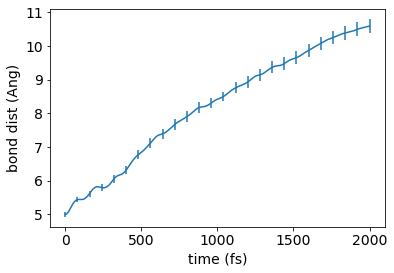

In [3]:
plt.plot(t_frames, avg_bond_dist, 'C0')
plt.errorbar(t_frames[::20], avg_bond_dist[::20], yerr=sem_bond_dist[::20], color='C0', linestyle='none')
plt.ylabel('bond dist (Ang)')
plt.xlabel('time (fs)')

With seesaw as 0 for Na(THF)4

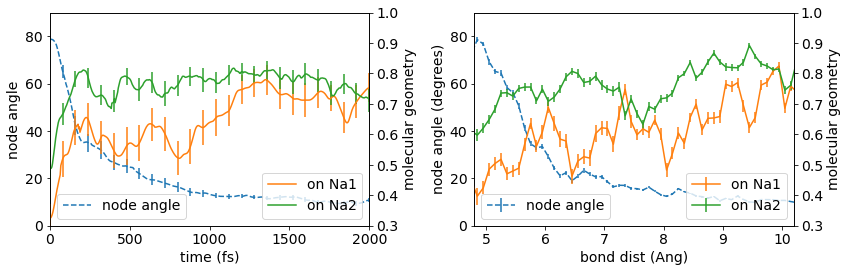

In [5]:
# with seesaw as 0 for Na(THF)4
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t_frames, avg_node_angle, 'C0--', label='node angle')
plt.errorbar(t_frames[::20], avg_node_angle[::20], yerr=sem_node_angle[::20], color='C0', linestyle='none')
plt.ylim([0,90])
plt.xlim([0,2000])
plt.legend(loc=3)
plt.ylabel('node angle')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(t_frames, avg_mol_geo[:,0], color='C1', label='on Na1')
plt.errorbar(t_frames[::20], avg_mol_geo[::20,0], color='C1', yerr=sem_mol_geo[::20,0], linestyle='none')
plt.plot(t_frames, avg_mol_geo[:,1], color='C2', label='on Na2')
plt.errorbar(t_frames[::20], avg_mol_geo[::20,1], color='C2', yerr=sem_mol_geo[::20,1], linestyle='none')
plt.ylim([0.3,1])
plt.ylabel('molecular geometry')
plt.legend(loc=4)

plt.subplot(1,2,2)
plt.errorbar(binned_angles[:,0], binned_angles[:,1], yerr=binned_angles[:,2], color='C0', linestyle='--', label='node angle')
plt.ylim([0,90])
plt.xlim([4.8, 10.2])
plt.ylabel('node angle (degrees)')
plt.xlabel('bond dist (Ang)')
plt.legend(loc=3)
plt.twinx()

plt.errorbar(binned_geo1[:,0], binned_geo1[:,1], yerr=binned_geo1[:,2], color='C1', label='on Na1')
plt.errorbar(binned_geo2[:,0], binned_geo2[:,1], yerr=binned_geo2[:,2], color='C2', label='on Na2')
plt.ylim([0.3,1])
plt.ylabel('molecular geometry')
plt.legend(loc=4)

plt.tight_layout()

In [5]:
plt.rcParams.update({'font.size': 16})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


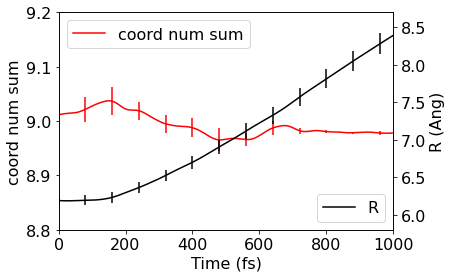

In [15]:
plt.plot(t_frames, avg_coord_num[:,0]+avg_coord_num[:,1], color='r', label='coord num sum')
plt.errorbar(t_frames[::20], avg_coord_num[::20,0]+avg_coord_num[::20,1], yerr=np.sqrt(sem_coord_num[::20,0]**2 + sem_coord_num[::20,1]**2), color='r', linestyle='none')
plt.legend(loc=2)
plt.ylabel('coord num sum')
plt.xlabel('Time (fs)')
plt.ylim([8.8, 9.2])
plt.xlim([0,1000])

plt.twinx()
plt.plot(t_frames, avg_com_dist, color='k', label='R')
plt.errorbar(t_frames[::20], avg_com_dist[::20], yerr=sem_com_dist[::20], color='k', linestyle='none')
plt.ylabel('R (Ang)')
plt.legend(loc=4)
plt.ylim([5.8,8.7])

plt.savefig('Na2+_THF_cluster/45/figs/avg_coord_num_and_com_dist_time.eps', format='eps')

In [10]:
liq_avg_coord = np.load('45liq_avg_coord.npy')
liq_sem_coord = np.load('45liq_sem_coord.npy')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


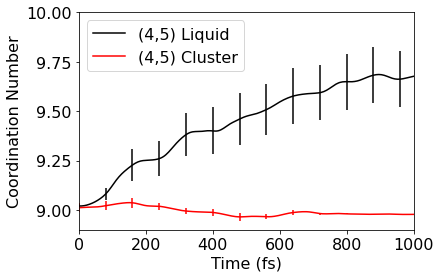

In [24]:
plt.plot(t_frames, liq_avg_coord[:501,0]+liq_avg_coord[:501,1], color='k', label='(4,5) Liquid')
plt.errorbar(t_frames[::20], liq_avg_coord[:501:20,0]+liq_avg_coord[:501:20,1], yerr=np.sqrt(liq_sem_coord[:501:20,0]**2 + liq_sem_coord[:501:20,1]**2), color='k', linestyle='none')
plt.plot(t_frames, avg_coord_num[:,0]+avg_coord_num[:,1], color='r', label='(4,5) Cluster')
plt.errorbar(t_frames[::20], avg_coord_num[::20,0]+avg_coord_num[::20,1], yerr=np.sqrt(sem_coord_num[::20,0]**2 + sem_coord_num[::20,1]**2), color='r', linestyle='none')
plt.legend(loc=2)
plt.ylabel('Coordination Number')
plt.xlabel('Time (fs)')
plt.ylim([8.9, 10])
plt.yticks([9.0, 9.25, 9.5, 9.75, 10.0])
plt.xlim([0,1000])

plt.savefig('Na2+_THF_cluster/45/figs/liq_cluster_avg_coord_num.eps', format='eps')

With square planar as 0 for Na(THF)4. Not as good as seesaw as 0

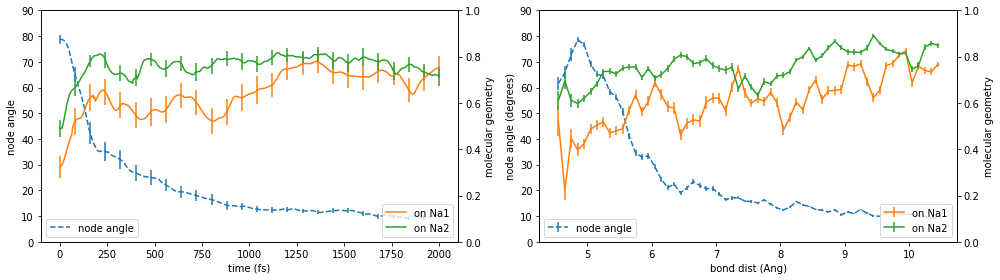

In [119]:
# with square planar as 0 for Na(THF)4
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(t_frames, avg_node_angle, 'C0--', label='node angle')
plt.errorbar(t_frames[::20], avg_node_angle[::20], yerr=sem_node_angle[::20], color='C0', linestyle='none')
plt.ylim([0,90])
plt.legend(loc=3)
plt.ylabel('node angle')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(t_frames, avg_mol_geo[:,0], color='C1', label='on Na1')
plt.errorbar(t_frames[::20], avg_mol_geo[::20,0], color='C1', yerr=sem_mol_geo[::20,0], linestyle='none')
plt.plot(t_frames, avg_mol_geo[:,1], color='C2', label='on Na2')
plt.errorbar(t_frames[::20], avg_mol_geo[::20,1], color='C2', yerr=sem_mol_geo[::20,1], linestyle='none')
plt.ylim([0,1])
plt.ylabel('molecular geometry')
plt.legend(loc=4)

plt.subplot(1,2,2)
plt.errorbar(binned_angles[:,0], binned_angles[:,1], yerr=binned_angles[:,2], color='C0', linestyle='--', label='node angle')
plt.ylim([0,90])
plt.ylabel('node angle (degrees)')
plt.xlabel('bond dist (Ang)')
plt.legend(loc=3)
plt.twinx()

plt.errorbar(binned_geo1[:,0], binned_geo1[:,1], yerr=binned_geo1[:,2], color='C1', label='on Na1')
plt.errorbar(binned_geo2[:,0], binned_geo2[:,1], yerr=binned_geo2[:,2], color='C2', label='on Na2')
plt.ylim([0,1])
plt.ylabel('molecular geometry')
plt.legend(loc=4)

plt.tight_layout()

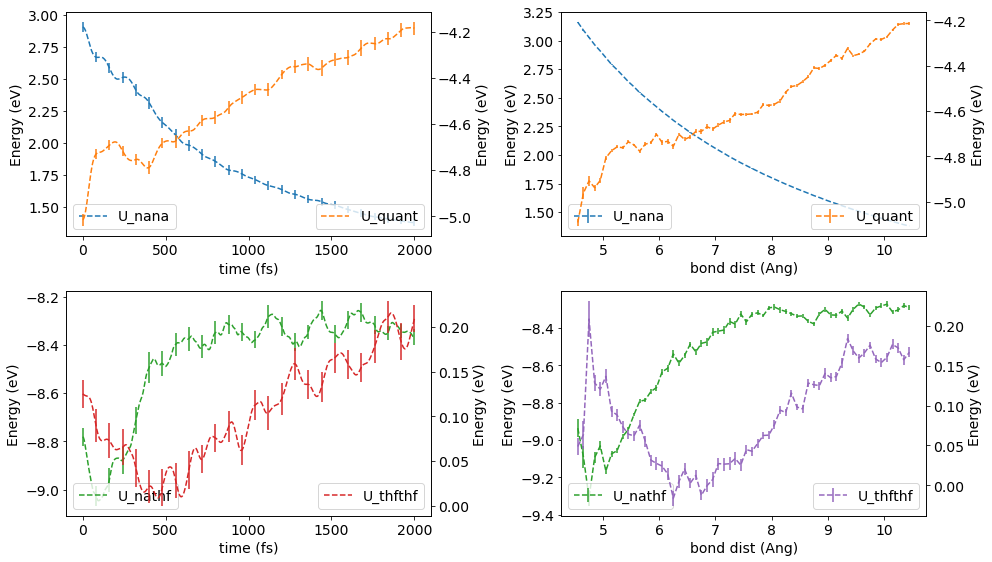

In [8]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(t_frames, avg_U_nana, 'C0--', label='U_nana')
plt.errorbar(t_frames[::20], avg_U_nana[::20], yerr=sem_U_nana[::20], color='C0', linestyle='none')
plt.legend(loc=3)
plt.ylabel('Energy (eV)')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(t_frames, avg_U_quant, 'C1--', label='U_quant')
plt.errorbar(t_frames[::20], avg_U_quant[::20], yerr=sem_U_quant[::20], color='C1', linestyle='none')
plt.legend(loc=4)
plt.ylabel('Energy (eV)')

plt.subplot(2,2,2)
plt.errorbar(binned_U_nana[:,0], binned_U_nana[:,1], yerr=binned_U_nana[:,2], color='C0', linestyle='--', label='U_nana')
plt.ylabel('Energy (eV)')
plt.xlabel('bond dist (Ang)')
plt.legend(loc=3)

plt.twinx()
plt.errorbar(binned_U_quant[:,0], binned_U_quant[:,1], yerr=binned_U_quant[:,2], color='C1', linestyle='--', label='U_quant')
plt.ylabel('Energy (eV)')
plt.legend(loc=4)

plt.subplot(2,2,3)
plt.plot(t_frames, avg_U_nathf, 'C2--', label='U_nathf')
plt.errorbar(t_frames[::20], avg_U_nathf[::20], yerr=sem_U_nathf[::20], color='C2', linestyle='none')
plt.legend(loc=3)
plt.ylabel('Energy (eV)')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(t_frames, avg_U_thfthf, 'C3--', label='U_thfthf')
plt.errorbar(t_frames[::20], avg_U_thfthf[::20], yerr=sem_U_thfthf[::20], color='C3', linestyle='none')
plt.legend(loc=4)
plt.ylabel('Energy (eV)')

plt.subplot(2,2,4)
plt.errorbar(binned_U_nathf[:,0], binned_U_nathf[:,1], yerr=binned_U_nathf[:,2], color='C2', linestyle='--', label='U_nathf')
plt.ylabel('Energy (eV)')
plt.xlabel('bond dist (Ang)')
plt.legend(loc=3)

plt.twinx()
plt.errorbar(binned_U_thfthf[:,0], binned_U_thfthf[:,1], yerr=binned_U_thfthf[:,2], color='C4', linestyle='--', label='U_thfthf')
plt.ylabel('Energy (eV)')
plt.legend(loc=4)

plt.tight_layout()

In [54]:
my_U_thfthf = lib.binScalarsBondDist(U_thfthf.flatten(), mol_geo[:,:,1].flatten(), 0.4, 1, 0.05)
my_U_nathf = lib.binScalarsBondDist(U_nathf.flatten(), mol_geo[:,:,1].flatten(), 0.4, 1, 0.05)

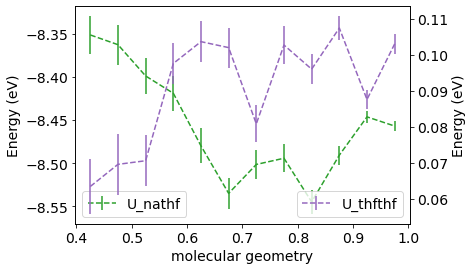

In [58]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(6,4))
plt.errorbar(my_U_nathf[:,0], my_U_nathf[:,1], yerr=my_U_nathf[:,2], color='C2', linestyle='--', label='U_nathf')
plt.ylabel('Energy (eV)')
plt.xlabel('molecular geometry')
plt.legend(loc=3)

plt.twinx()
plt.errorbar(my_U_thfthf[:,0], my_U_thfthf[:,1], yerr=my_U_thfthf[:,2], color='C4', linestyle='--', label='U_thfthf')
plt.ylabel('Energy (eV)')
plt.legend(loc=4)

In [25]:
plt.rcParams.update({'font.size': 20})

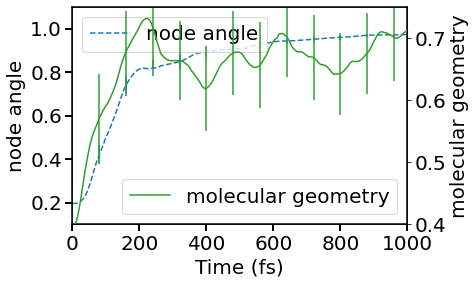

In [9]:
fig, axs = plt.subplots(figsize=(6,4))
axs.plot(t_frames, np.cos(avg_node_angle/180*np.pi), 'C0--', label='node angle')
axs.errorbar(t_frames[::20], np.cos(avg_node_angle[::20]/180*np.pi), yerr=np.sin(avg_node_angle[::20]/180*np.pi)*sem_node_angle[::20]/180*np.pi, color='C0', linestyle='none')
axs.set_ylim([0.1,1.1])
axs.set_xlim([0,1000])
axs.legend(loc=2)
axs.set_ylabel('node angle')
axs.set_xlabel('Time (fs)')

ax2 = axs.twinx()
ax2.plot(t_frames, (avg_mol_geo[:,0]+avg_mol_geo[:,1])/2, color='C2', label='molecular geometry')
ax2.errorbar(t_frames[::20], (avg_mol_geo[::20,0]+avg_mol_geo[::20,1])/2, color='C2', yerr=np.sqrt(sem_mol_geo[::20,0]**2+sem_mol_geo[::20,1]**2), linestyle='none')
ax2.set_ylim([0.4,0.75])
ax2.set_ylabel('molecular geometry')
ax2.legend(loc=4)

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')
axs.tick_params(which='major', length=7, width=2)

# plt.savefig('Na2+_THF_cluster/45/figs/node_angle_mol_geo.eps', format='eps')

In [8]:
sem_mol_geo[80,0] = sem_mol_geo[60,0]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


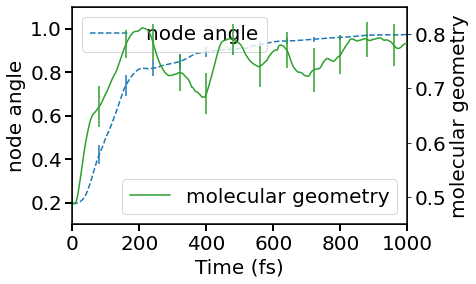

In [6]:
fig, axs = plt.subplots(figsize=(6,4))
axs.plot(t_frames, np.cos(avg_node_angle/180*np.pi), 'C0--', label='node angle')
axs.errorbar(t_frames[::20], np.cos(avg_node_angle[::20]/180*np.pi), yerr=np.sin(avg_node_angle[::20]/180*np.pi)*sem_node_angle[::20]/180*np.pi, color='C0', linestyle='none')
axs.set_ylim([0.1,1.1])
axs.set_xlim([0,1000])
axs.legend(loc=2)
axs.set_ylabel('node angle')
axs.set_xlabel('Time (fs)')

ax2 = axs.twinx()
ax2.plot(t_frames, avg_mol_geo[:,1], color='C2', label='molecular geometry')
ax2.errorbar(t_frames[::20], avg_mol_geo[::20,1], color='C2', yerr=sem_mol_geo[::20,1], linestyle='none')
ax2.set_ylim([0.45,0.85])
ax2.set_ylabel('molecular geometry')
ax2.legend(loc=4)

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')
axs.tick_params(which='major', length=7, width=2)

plt.savefig('Na2+_THF_cluster/45/figs/node_angle_mol_geo.eps', format='eps')

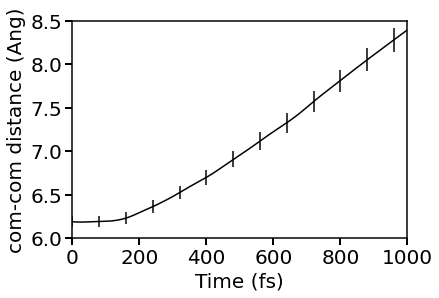

In [23]:
fig, axs = plt.subplots(figsize=(6,4))
axs.plot(t_frames, avg_com_dist, 'k')
axs.errorbar(t_frames[::20], avg_com_dist[::20], yerr=sem_com_dist[::20], color='k', linestyle='none')
axs.set_ylim([6,8.5])
axs.set_yticks(np.arange(6.0,9,0.5))
axs.set_xlim([0,1000])
axs.set_ylabel('com-com distance (Ang)')
axs.set_xlabel('Time (fs)')

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')
axs.tick_params(which='major', length=7, width=2)
# axs.tick_params(axis='x', labelsize=14)
# axs.tick_params(axis='y', labelsize=14)

plt.savefig('Na2+_THF_cluster/45/figs/com_dist_time.eps', format='eps')

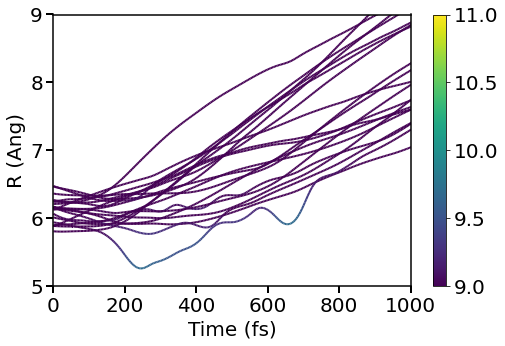

In [7]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig, axs = plt.subplots(figsize=(8,5))

dirs = np.arange(1,21)

x = t_frames
for i in range(len(dirs)):
    y = com_dist[i]
    dydx = coord_num[i,:,0] + coord_num[i,:,1]
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    norm = plt.Normalize(9, 11)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

axs.set_xlim(x.min(), x.max())
axs.set_ylim(5, 9)
axs.set_xlim([0,1000])
axs.set_xlabel('Time (fs)')
axs.set_ylabel('R (Ang)')

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')
axs.tick_params(which='major', length=7, width=2)
# axs.tick_params(axis='x', labelsize=14)
# axs.tick_params(axis='y', labelsize=14)
plt.savefig('Na2+_THF_cluster/45/figs/com_dist_time_swarm.eps', format='eps')
plt.show()

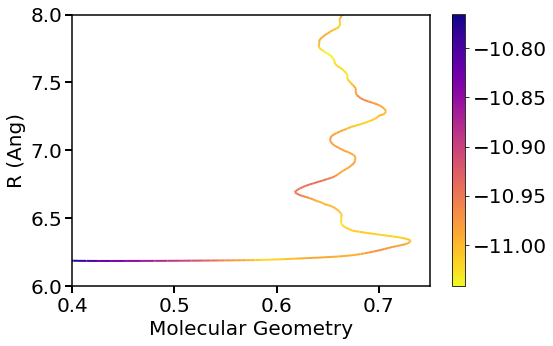

In [24]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig, axs = plt.subplots(figsize=(8,5))

x = (avg_mol_geo[:250,1]+avg_mol_geo[:250,0])/2
y = avg_com_dist[:250]
dydx = (avg_U_nathf+avg_U_thfthf+avg_U_quant+avg_U_nana)[:250]

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='plasma_r', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

axs.set_xlim(0.4,0.75)
axs.set_ylim(6, 8)
axs.set_xlabel('Molecular Geometry')
axs.set_ylabel('R (Ang)')

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')
axs.tick_params(which='major', length=7, width=2)
# axs.tick_params(axis='x', labelsize=14)
# axs.tick_params(axis='y', labelsize=14)
plt.savefig('Na2+_THF_cluster/45/figs/energy_2D.eps', format='eps')
plt.show()

In [21]:
avg_mol_geo[67:84,0] = avg_mol_geo[66,0] + (avg_mol_geo[85,0]-avg_mol_geo[66,0])/18*np.arange(1,18)

In [26]:
binned2d_U_nana = thf_lib.binScalars2D(U_nana.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 5.5, 8.5, 0.5, 0.4, 0.9, 0.05)
binned2d_U_nathf = thf_lib.binScalars2D(U_nathf.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 5.5, 8.5, 0.5, 0.4, 0.9, 0.05)
binned2d_U_thfthf = thf_lib.binScalars2D(U_thfthf.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 5.5, 8.5, 0.5, 0.4, 0.9, 0.05)
binned2d_U_quant = thf_lib.binScalars2D(U_quant.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 5.5, 8.5, 0.5, 0.4, 0.9, 0.05)

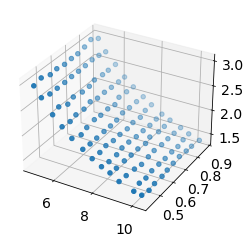

In [13]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter3D(binned2d_U_nana[:,:,0].flatten(), binned2d_U_nana[:,:,1].flatten(), binned2d_U_nana[:,:,2].flatten(), 'gray')

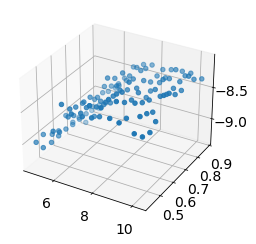

In [14]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter3D(binned2d_U_nathf[:,:,0].flatten(), binned2d_U_nathf[:,:,1].flatten(), binned2d_U_nathf[:,:,2].flatten(), 'gray')

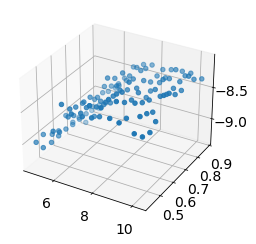

In [15]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.scatter3D(binned2d_U_nathf[:,:,0].flatten(), binned2d_U_nathf[:,:,1].flatten(), binned2d_U_nathf[:,:,2].flatten(), 'gray')

In [12]:
plt.rcParams.update({'font.size': 16})

<IPython.core.display.Javascript object>


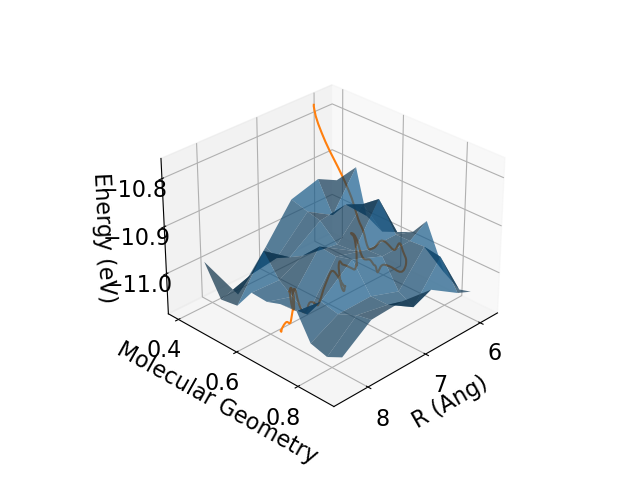

Text(0.5, 0, 'Energy (eV)')

In [28]:
%matplotlib notebook
plt.rcParams.update({'font.size': 16})
ax = plt.axes(projection='3d')
#ax.plot3D(bond_dist[0,:], mol_geo[0,:,1], U_nathf[0,:]+U_thfthf[0,:]+U_nana[0,:], 'C0')
# for i in np.arange(0,3):
#     ax.plot3D(com_dist[i,:], mol_geo[i,:,1], U_nathf[i,:]+U_thfthf[i,:]+U_nana[i,:], 'C'+str(i))
# ax.plot3D(avg_com_dist, avg_mol_geo[:,1], avg_U_nathf+avg_U_thfthf+avg_U_nana, 'gray')
# ax.plot3D(avg_bond_dist, avg_mol_geo[:,0], avg_U_nathf+avg_U_thfthf+avg_U_nana, 'C0')
ax.plot3D(avg_com_dist[:250], (avg_mol_geo[:250,1]+avg_mol_geo[:250,0])/2, avg_U_quant[:250]+avg_U_nana[:250]+avg_U_nathf[:250]+avg_U_thfthf[:250], 'C1')
# ax.plot_wireframe(binned2d_U_nana[:,:,0], binned2d_U_nana[:,:,1], binned2d_U_quant[:,:,2], color='gray')
ax.plot_surface(binned2d_U_nathf[:,:,0], binned2d_U_nathf[:,:,1], binned2d_U_nathf[:,:,2]+
                  binned2d_U_thfthf[:,:,2]+binned2d_U_nana[:,:,2]+binned2d_U_quant[:,:,2], rstride=1, cstride=1, alpha=0.7)
# ax.contour3D(binned2d_U_nathf[:,:,0], binned2d_U_nathf[:,:,1],binned2d_U_nana[:,:,2]+
#                   binned2d_U_quant[:,:,2]+binned2d_U_nathf[:,:,2]+binned2d_U_thfthf[:,:,2], 50)
ax.set_xlabel('R (Ang)')
ax.set_ylabel('Molecular Geometry')
ax.set_zlabel('Energy (eV)')

In [ ]:
plt.savefig('Na2+_THF_cluster/45/figs/energy_surf.eps', format='eps')

Playing around with numerical derivative of energy surface

In [7]:
def derivU2D(U):
    (a,b) = np.shape(U)[:2]
    dU = np.zeros([a,b,6])

    for i in range(a-1):
        for j in range(b-1):
            (dx1, dy1) = (U[i+1,j,0]-U[i,j,0], U[i+1,j,1]-U[i,j,1])
            (dx2, dy2) = (U[i,j+1,0]-U[i,j,0], U[i,j+1,1]-U[i,j,1])
            (dU1, dU2) = (U[i+1,j,2]-U[i,j,2], U[i,j+1,2]-U[i,j,2])
            
            dU[i,j,2] = (dU1/dx1 - dy1*dU2/(dy2*dx1))/(1-dy1*dx2/(dy2*dx1))
            dU[i,j,3] = (dU1/dy1 - dx1*dU2/(dx2*dy1))/(1-dx1*dy2/(dx2*dy1))
            
#             dU[i,j,2] = (U[i+1,j,2] - U[i,j,2])/dx
#             dU[i,j,3] = (U[i,j+1,2] - U[i,j,2])/dy

#             dU[i,j,4] = np.sqrt((U[i+1,j,3]**2 + U[i,j,3]**2))/dx
#             dU[i,j,5] = np.sqrt((U[i,j+1,3]**2 + U[i,j,3]**2))/dy

    dU[:,:,0] = U[:,:,0]
    dU[:,:,1] = U[:,:,1]
    return dU

In [8]:
dU_nana_2D = derivU2D(binned2d_U_nana)
dU_nathf_2D = derivU2D(binned2d_U_nathf)
dU_thfthf_2D = derivU2D(binned2d_U_thfthf)
dU_quant_2D = derivU2D(binned2d_U_quant)

<IPython.core.display.Javascript object>


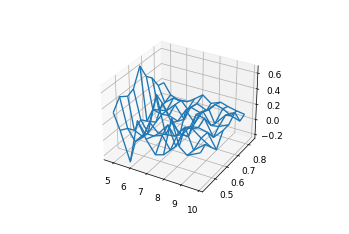

In [97]:
%matplotlib notebook
ax = plt.axes(projection='3d')
# ax.plot_wireframe(dU_nana_2D[:-1,:-1,0], dU_nana_2D[:-1,:-1,1],dU_nana_2D[:-1,:-1,3])
ax.plot_wireframe(dU_nathf_2D[:-1,:-1,0], dU_nathf_2D[:-1,:-1,1],dU_quant_2D[:-1,:-1,2])
# ax.plot_wireframe(dU_nana_2D[:-1,:-1,0], dU_nana_2D[:-1,:-1,1],dU_thfthf_2D[:-1,:-1,3])
# ax.plot_wireframe(dU_nana_2D[:-1,:-1,0], dU_nana_2D[:-1,:-1,1],dU_quant_2D[:-1,:-1,2])
# ax.plot_wireframe(binned2d_U_nana[:,:,0], binned2d_U_nana[:,:,1], binned2d_U_quant[:,:,2])

In [60]:
(r0, r, dr) = (4.5, 10.5, 0.5)
(h0, h, dh) = (0.4, 0.9, 0.05)
print(avg_bond_dist[0], avg_mol_geo[0,1])
print(int((avg_bond_dist[0]-r0)/dr), int((avg_mol_geo[0,1]-h0)/dh))

4.99251132360057 0.49037905821381134
0 1


In [53]:
(i,j) = (0,3)
(dx1, dy1) = (binned2d_U_nana[i+1,j,0]-binned2d_U_nana[i,j,0], binned2d_U_nana[i+1,j,1]-binned2d_U_nana[i,j,1])
(dx2, dy2) = (binned2d_U_nana[i,j+1,0]-binned2d_U_nana[i,j,0], binned2d_U_nana[i,j+1,1]-binned2d_U_nana[i,j,1])
(dx3, dy3) = (binned2d_U_nana[i+1,j+1,0]-binned2d_U_nana[i,j,0], binned2d_U_nana[i+1,j+1,1]-binned2d_U_nana[i,j,1])
(dU1, dU2) = (binned2d_U_nana[i+1,j,2]-binned2d_U_nana[i,j,2], binned2d_U_nana[i,j+1,2]-binned2d_U_nana[i,j,2])
dU3 = binned2d_U_nana[i+1,j+1,2] - binned2d_U_nana[i,j,2]

In [90]:
(i,j) = (0,1)
print(dU_nana_2D[i,j,2], dU_nana_2D[i,j,3])
print(dU_nathf_2D[i,j,2], dU_nathf_2D[i,j,3])
print(dU_thfthf_2D[i,j,2], dU_thfthf_2D[i,j,3])
print(dU_quant_2D[i,j,2], dU_quant_2D[i,j,3])

-0.568079842373987 -0.08012062762224254
-0.18326895131585652 -1.504879563154293
-0.2559496502418847 -0.09912891313547935
0.46856861870685523 0.5296359634807485


Text(0.5, 0, 'time (fs)')

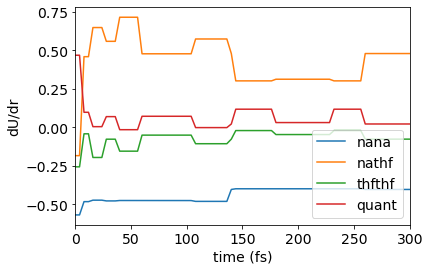

In [103]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})
r_ind = [int((avg_bond_dist[i]-r0)/dr) for i in range(250)]
h_ind = [int((avg_mol_geo[i,1]-h0)/dh) for i in range(250)]

plt.plot(t_frames[:250], dU_nana_2D[r_ind,h_ind,2], label='nana')
plt.plot(t_frames[:250], dU_nathf_2D[r_ind,h_ind,2], label='nathf')
plt.plot(t_frames[:250], dU_thfthf_2D[r_ind,h_ind,2], label='thfthf')
plt.plot(t_frames[:250], dU_quant_2D[r_ind,h_ind,2], label='quant')

plt.legend(loc=4)
plt.xlim([0,300])
plt.ylabel('dU/dr')
plt.xlabel('time (fs)')

Text(0.5, 0, 'time (fs)')

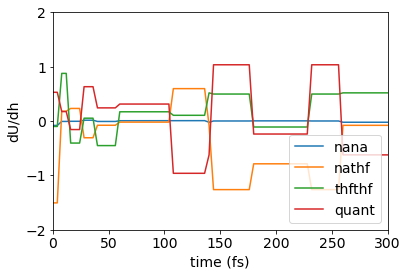

In [105]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})
r_ind = [int((avg_bond_dist[i]-r0)/dr) for i in range(250)]
h_ind = [int((avg_mol_geo[i,1]-h0)/dh) for i in range(250)]

plt.plot(t_frames[:250], dU_nana_2D[r_ind,h_ind,3], label='nana')
plt.plot(t_frames[:250], dU_nathf_2D[r_ind,h_ind,3], label='nathf')
plt.plot(t_frames[:250], dU_thfthf_2D[r_ind,h_ind,3], label='thfthf')
plt.plot(t_frames[:250], dU_quant_2D[r_ind,h_ind,3], label='quant')

plt.legend(loc=4)
plt.ylim([-2,2])
plt.xlim([0,300])
plt.ylabel('dU/dh')
plt.xlabel('time (fs)')

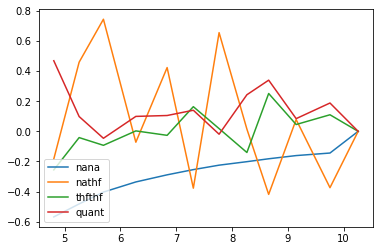

In [67]:
%matplotlib inline
plt.plot(dU_nana_2D[:,1,0], dU_nana_2D[:,1,2], label='nana')
plt.plot(dU_nana_2D[:,1,0], dU_nathf_2D[:,1,2], label='nathf')
plt.plot(dU_nana_2D[:,1,0], dU_thfthf_2D[:,1,2], label='thfthf')
plt.plot(dU_nana_2D[:,1,0], dU_quant_2D[:,1,2], label='quant')
plt.legend(loc=3)

In [22]:
print(binned2d_U_nana[i+1,j,2] - binned2d_U_nana[i,j,2])
print(dU_nana_2D[i,j,2]*dx1 + dU_nana_2D[i,j,3]*dy1)

-0.20968174214253432
-0.20968174214253432


In [23]:
print(binned2d_U_nana[i,j+1,2] - binned2d_U_nana[i,j,2])
print(dU_nana_2D[i,j,2]*dx2 + dU_nana_2D[i,j,3]*dy2)

0.000484204865810689
0.000484204865810689


In [24]:
print(binned2d_U_nana[i+1,j+1,2] - binned2d_U_nana[i,j,2])
print(dU_nana_2D[i,j,2]*dx3 + dU_nana_2D[i,j,3]*dy3)

-0.255330753048872
-0.26048635249277224


In [78]:
(a,b) = np.shape(dU_nathf_2D)[:2]
diff = np.zeros([a-1,b-1])
for i in range(a-1):
    for j in range(b-1):
        (dx1, dy1) = (binned2d_U_nathf[i+1,j,0]-binned2d_U_nathf[i,j,0], binned2d_U_nathf[i+1,j,1]-binned2d_U_nathf[i,j,1])
        (dx2, dy2) = (binned2d_U_nathf[i,j+1,0]-binned2d_U_nathf[i,j,0], binned2d_U_nathf[i,j+1,1]-binned2d_U_nathf[i,j,1])
        (dx3, dy3) = (binned2d_U_nathf[i+1,j+1,0]-binned2d_U_nathf[i,j,0], binned2d_U_nathf[i+1,j+1,1]-binned2d_U_nathf[i,j,1])
        (dU1, dU2) = (binned2d_U_nathf[i+1,j,2]-binned2d_U_nathf[i,j,2], binned2d_U_nathf[i,j+1,2]-binned2d_U_nathf[i,j,2])
        dU3 = binned2d_U_nathf[i+1,j+1,2] - binned2d_U_nathf[i,j,2]
        
        diff[i,j] = (dU1-dU_nathf_2D[i,j,2]*dx1-dU_nathf_2D[i,j,3]*dy1)/dU1
        diff[i,j] += (dU2-dU_nathf_2D[i,j,2]*dx2-dU_nathf_2D[i,j,3]*dy2)/dU2
        diff[i,j] += (dU3-dU_nathf_2D[i,j,2]*dx3-dU_nathf_2D[i,j,3]*dy3)/dU3

<IPython.core.display.Javascript object>


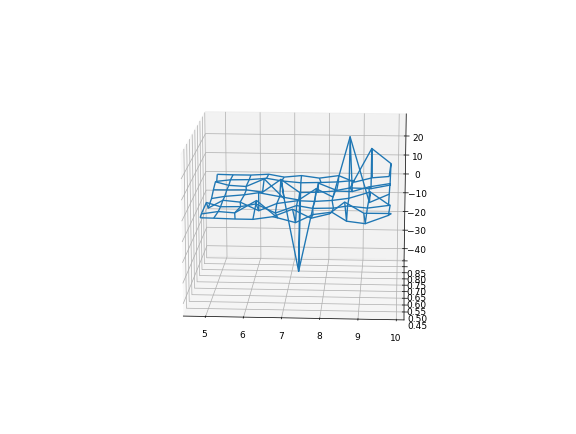

In [79]:
%matplotlib notebook
ax = plt.axes(projection='3d')
ax.plot_wireframe(dU_nana_2D[:-1,:-1,0], dU_nana_2D[:-1,:-1,1],diff)

In [15]:
print(dx1, dy1)

0.35213973156301126 0.0027348647603170906


In [16]:
dU_nana_2D[0,0,3]*dy1/(binned2d_U_nana[1,0,2] - binned2d_U_nana[0,0,2])

-0.0006662102070446083

In [17]:
print(dU_nana_2D[-2,0,0], dU_nana_2D[-2,0,2])

9.83274349029522 -0.14314108956410285


Numerical derivative too noisy to be useful

### For (5,5)

In [2]:
# to load data for each directory and each time point. use to save time
t_frames = np.arange(0,2004,4)
bond_dist = np.load('Na2+_THF_cluster/55/bond_dist.npy')
com_dist = np.load('Na2+_THF_cluster/55/com_dist.npy')
coord_num = np.load('Na2+_THF_cluster/55/coord_num.npy')
node_angle = np.load('Na2+_THF_cluster/55/node_angle.npy')
mol_geo = np.load('Na2+_THF_cluster/55/mol_geo.npy')
U_nana = np.load('Na2+_THF_cluster/55/U_nana.npy')
U_nathf = np.load('Na2+_THF_cluster/55/U_nathf.npy')
U_thfthf = np.load('Na2+_THF_cluster/55/U_thfthf.npy')
U_quant = np.load('Na2+_THF_cluster/55/U_quant.npy')

In [3]:
avg_bond_dist = np.average(bond_dist, axis=0)
sem_bond_dist = stats.sem(bond_dist, axis=0)
std_bond_dist = np.std(bond_dist, axis=0)
avg_com_dist = np.average(com_dist, axis=0)
sem_com_dist = stats.sem(com_dist, axis=0)
std_com_dist = np.std(com_dist, axis=0)
avg_coord_num = np.average(coord_num, axis=0) 
sem_coord_num = stats.sem(coord_num, axis=0)
std_coord_num = np.std(coord_num, axis=0)
avg_node_angle = np.average(node_angle, axis=0)
sem_node_angle = stats.sem(node_angle, axis=0)
std_node_angle = np.std(node_angle, axis=0)
avg_mol_geo = np.average(mol_geo, axis=0)
sem_mol_geo = stats.sem(mol_geo, axis=0)
std_mol_geo = np.std(mol_geo, axis=0)
avg_U_nana = np.average(U_nana, axis=0)
sem_U_nana = stats.sem(U_nana, axis=0)
avg_U_nathf = np.average(U_nathf, axis=0)
sem_U_nathf = stats.sem(U_nathf, axis=0)
avg_U_thfthf = np.average(U_thfthf, axis=0)
sem_U_thfthf = stats.sem(U_thfthf, axis=0)
avg_U_quant = np.average(U_quant, axis=0)
sem_U_quant = stats.sem(U_quant, axis=0)

In [4]:
binned_angles = lib.binScalarsBondDist(node_angle.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_geo1 = lib.binScalarsBondDist(mol_geo[:,:,0].flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_geo2 = lib.binScalarsBondDist(mol_geo[:,:,1].flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_U_nana = lib.binScalarsBondDist(U_nana.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_U_nathf = lib.binScalarsBondDist(U_nathf.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_U_thfthf = lib.binScalarsBondDist(U_thfthf.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)
binned_U_quant = lib.binScalarsBondDist(U_quant.flatten(), bond_dist.flatten(), 4.5, 10.5, 0.1)

/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/u/local/apps/anaconda3/2020.11/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
root = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/55/'
dirs = np.arange(1,21)

(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

bond_dist = np.zeros([len(dirs), len(t_frames)])
com_dist = np.zeros([len(dirs), len(t_frames)])
coord_num = np.zeros([len(dirs), len(t_frames), 2])
node_angle = np.zeros([len(dirs), len(t_frames)])
mol_geo = np.zeros([len(dirs), len(t_frames), 2])
for i in range(len(dirs)):
    my_dir = root+str(dirs[i])
    dipole = np.loadtxt(my_dir+'/out.dip')[int(t0/4):int(t/4+1):int(dt/4),3:6]
    bond_dist[i] = np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4),1]
    com = thf_lib.calcCOMPosConf(my_dir, t0, t, dt)
    com_dist[i] = np.array([thf_lib.dist(com[j,0,:], com[j,1,:]) for j in range(len(t_frames))])
    for j in range(len(t_frames)):
        r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[j])
        coord_num[i,j] = thf_lib.calcCoordNum(r_Na, r_THF)
        node_angle[i,j] = thf_lib.calcNodeAngle(r_Na, dipole[j])
        # calculating molecular geometry
        coord_indices = thf_lib.findCoordIndex(r_Na, r_THF)[0]
        na1_indices = 5*np.array([n for n in coord_indices[0] if n >= 0])
        na2_indices = 5*np.array([n for n in coord_indices[1] if n >= 0])
        mol_geo[i,j,0] = thf_lib.calcMolGeo(r_Na[0], r_THF[na1_indices])
        mol_geo[i,j,1] = thf_lib.calcMolGeo(r_Na[1], r_THF[na2_indices])

In [25]:
root = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/55/'
dirs = np.arange(1,21)

(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

U_nana = np.zeros([len(dirs), len(t_frames)])
U_nathf = np.zeros([len(dirs), len(t_frames)])
U_thfthf = np.zeros([len(dirs), len(t_frames)])
U_quant = np.zeros([len(dirs), len(t_frames)])
for d in range(len(dirs)):
    my_dir = root+str(dirs[d])
    U_quant[d] = np.loadtxt(my_dir+'/out.quante2')[int(t0/4):int(t/4+1):int(dt/4),1]
    for i in range(len(t_frames)):
        r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[i])
        
        U_nana[d,i] = thf_lib.calcUNaNa(r_Na[0], r_Na[1])
        for j in range(int(len(r_THF)/5)):
            U_nathf[d,i] += thf_lib.calcUNaTHF(r_Na[0], r_THF[5*j:5*(j+1)])
            U_nathf[d,i] += thf_lib.calcUNaTHF(r_Na[1], r_THF[5*j:5*(j+1)])
        for j in range(int(len(r_THF)/5-1)):
            for k in range(j+1,int(len(r_THF)/5)):
                U_thfthf[d,i] += thf_lib.calcUTHFTHF(r_THF[5*j:5*(j+1)], r_THF[5*k:5*(k+1)])

In [26]:
np.save('Na2+_THF_cluster/55/bond_dist.npy', bond_dist)
np.save('Na2+_THF_cluster/55/com_dist.npy', com_dist)
np.save('Na2+_THF_cluster/55/coord_num.npy', coord_num)
np.save('Na2+_THF_cluster/55/node_angle.npy', node_angle)
np.save('Na2+_THF_cluster/55/mol_geo.npy', mol_geo)
np.save('Na2+_THF_cluster/55/U_nana.npy', U_nana)
np.save('Na2+_THF_cluster/55/U_nathf.npy', U_nathf)
np.save('Na2+_THF_cluster/55/U_thfthf.npy', U_thfthf)
np.save('Na2+_THF_cluster/55/U_quant.npy', U_quant)

In [132]:
binned_angles = lib.binScalarsBondDist(node_angle.flatten(), bond_dist.flatten(), 5.6, 10.5, 0.1)
binned_geo1 = lib.binScalarsBondDist(mol_geo[:,:,0].flatten(), bond_dist.flatten(), 5.6, 10.5, 0.1)
binned_geo2 = lib.binScalarsBondDist(mol_geo[:,:,1].flatten(), bond_dist.flatten(), 5.6, 10.5, 0.1)

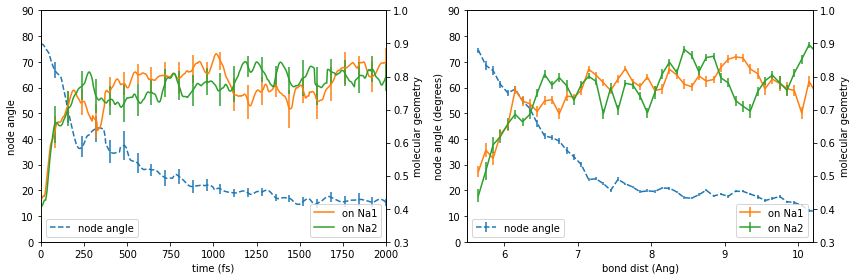

In [111]:
# with seesaw as 0 for Na(THF)4
%matplotlib inline
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t_frames, avg_node_angle, 'C0--', label='node angle')
plt.errorbar(t_frames[::20], avg_node_angle[::20], yerr=sem_node_angle[::20], color='C0', linestyle='none')
plt.ylim([0,90])
plt.xlim([0,2000])
plt.legend(loc=3)
plt.ylabel('node angle')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(t_frames, avg_mol_geo[:,0], color='C1', label='on Na1')
plt.errorbar(t_frames[::20], avg_mol_geo[::20,0], color='C1', yerr=sem_mol_geo[::20,0], linestyle='none')
plt.plot(t_frames, avg_mol_geo[:,1], color='C2', label='on Na2')
plt.errorbar(t_frames[::20], avg_mol_geo[::20,1], color='C2', yerr=sem_mol_geo[::20,1], linestyle='none')
plt.ylim([0.3,1])
plt.ylabel('molecular geometry')
plt.legend(loc=4)

plt.subplot(1,2,2)
plt.errorbar(binned_angles[:,0], binned_angles[:,1], yerr=binned_angles[:,2], color='C0', linestyle='--', label='node angle')
plt.ylim([0,90])
plt.xlim([5.5, 10.2])
plt.ylabel('node angle (degrees)')
plt.xlabel('bond dist (Ang)')
plt.legend(loc=3)
plt.twinx()

plt.errorbar(binned_geo1[:,0], binned_geo1[:,1], yerr=binned_geo1[:,2], color='C1', label='on Na1')
plt.errorbar(binned_geo2[:,0], binned_geo2[:,1], yerr=binned_geo2[:,2], color='C2', label='on Na2')
plt.ylim([0.3,1])
plt.ylabel('molecular geometry')
plt.legend(loc=4)

plt.tight_layout()

In [133]:
root = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/55/'
dirs = np.arange(1,21)

(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

bond_dist = np.zeros([len(dirs), len(t_frames)])
U_nana = np.zeros([len(dirs), len(t_frames)])
U_nathf = np.zeros([len(dirs), len(t_frames)])
U_thfthf = np.zeros([len(dirs), len(t_frames)])
U_quant = np.zeros([len(dirs), len(t_frames)])
for d in range(len(dirs)):
    my_dir = root+str(dirs[d])
    U_quant[d] = np.loadtxt(my_dir+'/out.quante2')[int(t0/4):int(t/4+1):int(dt/4),1]
    bond_dist[d] = np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4),1]
    for i in range(len(t_frames)):
        r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[i])
        
        U_nana[d,i] = thf_lib.calcUNaNa(r_Na[0], r_Na[1])
        for j in range(int(len(r_THF)/5)):
            U_nathf[d,i] += thf_lib.calcUNaTHF(r_Na[0], r_THF[5*j:5*(j+1)])
            U_nathf[d,i] += thf_lib.calcUNaTHF(r_Na[1], r_THF[5*j:5*(j+1)])
        for j in range(int(len(r_THF)/5-1)):
            for k in range(j+1,int(len(r_THF)/5)):
                U_thfthf[d,i] += thf_lib.calcUTHFTHF(r_THF[5*j:5*(j+1)], r_THF[5*k:5*(k+1)])
avg_U_nana = np.average(U_nana, axis=0)
sem_U_nana = stats.sem(U_nana, axis=0)
avg_U_nathf = np.average(U_nathf, axis=0)
sem_U_nathf = stats.sem(U_nathf, axis=0)
avg_U_thfthf = np.average(U_thfthf, axis=0)
sem_U_thfthf = stats.sem(U_thfthf, axis=0)
avg_U_quant = np.average(U_quant, axis=0)
sem_U_quant = stats.sem(U_quant, axis=0)
avg_bond_dist = np.average(bond_dist, axis=0)
sem_bond_dist = stats.sem(bond_dist, axis=0)

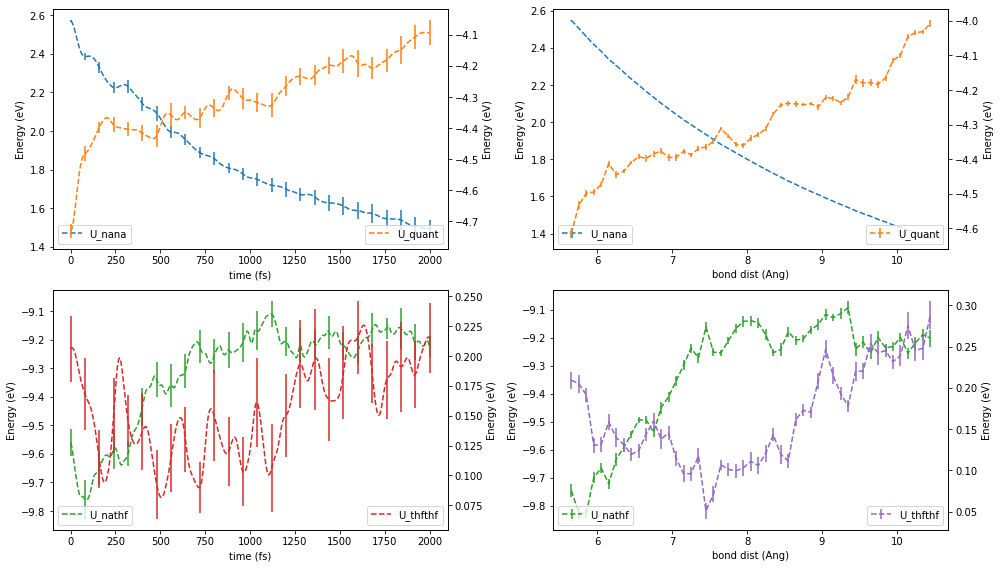

In [113]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(t_frames, avg_U_nana, 'C0--', label='U_nana')
plt.errorbar(t_frames[::20], avg_U_nana[::20], yerr=sem_U_nana[::20], color='C0', linestyle='none')
plt.legend(loc=3)
plt.ylabel('Energy (eV)')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(t_frames, avg_U_quant, 'C1--', label='U_quant')
plt.errorbar(t_frames[::20], avg_U_quant[::20], yerr=sem_U_quant[::20], color='C1', linestyle='none')
plt.legend(loc=4)
plt.ylabel('Energy (eV)')

plt.subplot(2,2,2)
plt.errorbar(binned_U_nana[:,0], binned_U_nana[:,1], yerr=binned_U_nana[:,2], color='C0', linestyle='--', label='U_nana')
plt.ylabel('Energy (eV)')
plt.xlabel('bond dist (Ang)')
plt.legend(loc=3)

plt.twinx()
plt.errorbar(binned_U_quant[:,0], binned_U_quant[:,1], yerr=binned_U_quant[:,2], color='C1', linestyle='--', label='U_quant')
plt.ylabel('Energy (eV)')
plt.legend(loc=4)

plt.subplot(2,2,3)
plt.plot(t_frames, avg_U_nathf, 'C2--', label='U_nathf')
plt.errorbar(t_frames[::20], avg_U_nathf[::20], yerr=sem_U_nathf[::20], color='C2', linestyle='none')
plt.legend(loc=3)
plt.ylabel('Energy (eV)')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(t_frames, avg_U_thfthf, 'C3--', label='U_thfthf')
plt.errorbar(t_frames[::20], avg_U_thfthf[::20], yerr=sem_U_thfthf[::20], color='C3', linestyle='none')
plt.legend(loc=4)
plt.ylabel('Energy (eV)')

plt.subplot(2,2,4)
plt.errorbar(binned_U_nathf[:,0], binned_U_nathf[:,1], yerr=binned_U_nathf[:,2], color='C2', linestyle='--', label='U_nathf')
plt.ylabel('Energy (eV)')
plt.xlabel('bond dist (Ang)')
plt.legend(loc=3)

plt.twinx()
plt.errorbar(binned_U_thfthf[:,0], binned_U_thfthf[:,1], yerr=binned_U_thfthf[:,2], color='C4', linestyle='--', label='U_thfthf')
plt.ylabel('Energy (eV)')
plt.legend(loc=4)

plt.tight_layout()

In [9]:
my_U_thfthf = lib.binScalarsBondDist(U_thfthf.flatten(), mol_geo[:,:,1].flatten(), 0.4, 1, 0.05)
my_U_nathf = lib.binScalarsBondDist(U_nathf.flatten(), mol_geo[:,:,1].flatten(), 0.4, 1, 0.05)

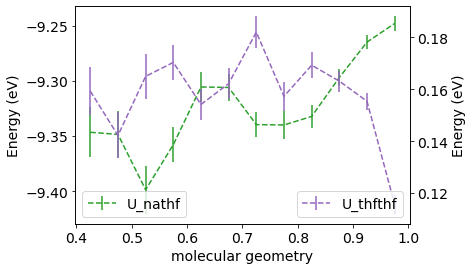

In [10]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(6,4))
plt.errorbar(my_U_nathf[:,0], my_U_nathf[:,1], yerr=my_U_nathf[:,2], color='C2', linestyle='--', label='U_nathf')
plt.ylabel('Energy (eV)')
plt.xlabel('molecular geometry')
plt.legend(loc=3)

plt.twinx()
plt.errorbar(my_U_thfthf[:,0], my_U_thfthf[:,1], yerr=my_U_thfthf[:,2], color='C4', linestyle='--', label='U_thfthf')
plt.ylabel('Energy (eV)')
plt.legend(loc=4)

In [30]:
binned2d_U_nana = thf_lib.binScalars2D(U_nana.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 6, 10, 0.5, 0.4, 1, 0.05)
binned2d_U_nathf = thf_lib.binScalars2D(U_nathf.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 6, 10, 0.5, 0.4, 1, 0.05)
binned2d_U_thfthf = thf_lib.binScalars2D(U_thfthf.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 6, 10, 0.5, 0.4, 1, 0.05)
binned2d_U_quant = thf_lib.binScalars2D(U_quant.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 6, 10, 0.5, 0.4, 1, 0.05)

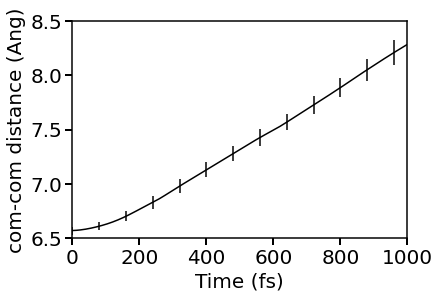

In [33]:
fig, axs = plt.subplots(figsize=(6,4))
axs.plot(t_frames, avg_com_dist, 'k')
axs.errorbar(t_frames[::20], avg_com_dist[::20], yerr=sem_com_dist[::20], color='k', linestyle='none')
axs.set_ylim([6.5,8.5])
axs.set_yticks(np.arange(6.5,9,0.5))
axs.set_xlim([0,1000])
axs.set_ylabel('com-com distance (Ang)')
axs.set_xlabel('Time (fs)')

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')
axs.tick_params(which='major', length=7, width=2)
# axs.tick_params(axis='x', labelsize=14)
# axs.tick_params(axis='y', labelsize=14)

plt.savefig('Na2+_THF_cluster/55/figs/com_dist_time.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


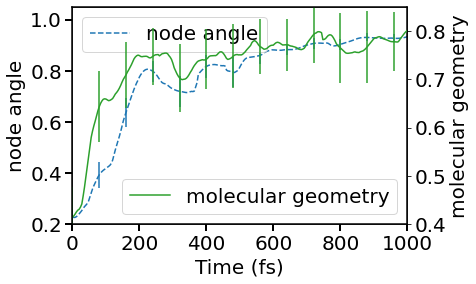

In [26]:
%matplotlib inline
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(figsize=(6,4))
axs.plot(t_frames, np.cos(avg_node_angle/180*np.pi), 'C0--', label='node angle')
axs.errorbar(t_frames[::20], np.cos(avg_node_angle[::20]/180*np.pi), yerr=np.sin(avg_node_angle[::20]/180*np.pi)*sem_node_angle[::20]/180*np.pi, color='C0', linestyle='none')
axs.set_ylim([0.2,1.05])
axs.set_xlim([0,1000])
axs.legend(loc=2)
axs.set_ylabel('node angle')
axs.set_xlabel('Time (fs)')

ax2 = axs.twinx()
ax2.plot(t_frames, (avg_mol_geo[:,1]+avg_mol_geo[:,0])/2, color='C2', label='molecular geometry')
ax2.errorbar(t_frames[::20], (avg_mol_geo[::20,1]+avg_mol_geo[::20,0])/2, color='C2', yerr=np.sqrt(sem_mol_geo[::20,1]**2+sem_mol_geo[::20,0]**2), linestyle='none')
ax2.set_ylim([0.4,0.85])
ax2.set_ylabel('molecular geometry')
ax2.legend(loc=4)

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')
axs.tick_params(which='major', length=7, width=2)

plt.savefig('Na2+_THF_cluster/55/figs/node_angle_mol_geo.eps', format='eps')

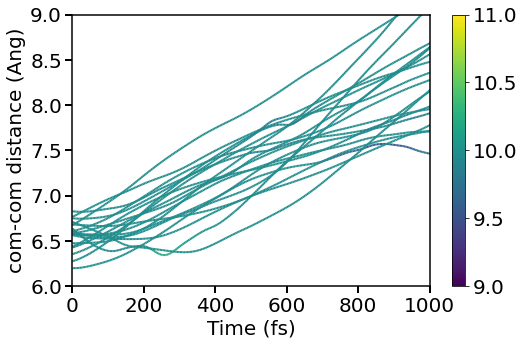

In [6]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig, axs = plt.subplots(figsize=(8,5))

dirs = np.arange(2,21)

x = t_frames
for i in range(len(dirs)):
    y = com_dist[i]
    dydx = coord_num[i,:,0] + coord_num[i,:,1]
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    norm = plt.Normalize(9, 11)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(dydx)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

axs.set_xlim(x.min(), x.max())
axs.set_ylim(6, 9)
axs.set_xlim([0,1000])
axs.set_xlabel('Time (fs)')
axs.set_ylabel('com-com distance (Ang)')

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')
axs.tick_params(which='major', length=7, width=2)
# axs.tick_params(axis='x', labelsize=14)
# axs.tick_params(axis='y', labelsize=14)
plt.savefig('Na2+_THF_cluster/55/figs/com_dist_time_swarm.eps', format='eps')
plt.show()

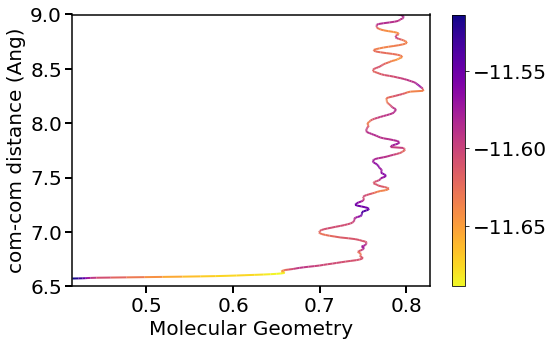

In [5]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig, axs = plt.subplots(figsize=(8,5))

x = (avg_mol_geo[:,1]+avg_mol_geo[:,0])/2
y = avg_com_dist
dydx = avg_U_nathf+avg_U_thfthf+avg_U_quant+avg_U_nana

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='plasma_r', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

axs.set_xlim(x.min(), x.max())
axs.set_ylim(6.5, 9)
axs.set_xlabel('Molecular Geometry')
axs.set_ylabel('com-com distance (Ang)')

axs.spines['top'].set_linewidth(1.5)
axs.spines['top'].set_color('k')
axs.spines['bottom'].set_linewidth(1.5)
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_linewidth(1.5)
axs.spines['left'].set_color('k')
axs.spines['right'].set_linewidth(1.5)
axs.spines['right'].set_color('k')
axs.tick_params(which='major', length=7, width=2)
# axs.tick_params(axis='x', labelsize=14)
# axs.tick_params(axis='y', labelsize=14)
plt.savefig('Na2+_THF_cluster/55/figs/energy_2D.eps', format='eps')
plt.show()

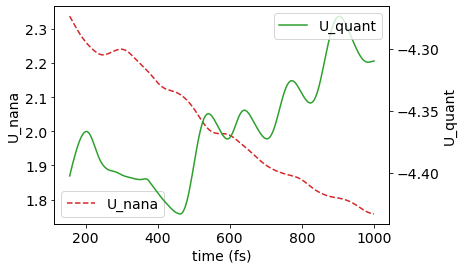

In [26]:
plt.plot(t_frames[39:251], avg_U_nana[39:251], 'C3--', label='U_nana')
plt.ylabel('U_nana')
plt.xlabel('time (fs)')
plt.legend(loc=3)
plt.twinx()
plt.plot(t_frames[39:251], avg_U_quant[39:251],'C2', label='U_quant')
plt.ylabel('U_quant')
plt.legend(loc=1)

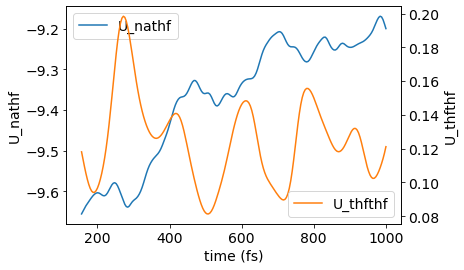

In [27]:
plt.plot(t_frames[39:251], avg_U_nathf[39:251], label='U_nathf')
plt.ylabel('U_nathf')
plt.xlabel('time (fs)')
plt.legend(loc=2)
plt.twinx()
plt.plot(t_frames[39:251], avg_U_thfthf[39:251],'C1', label='U_thfthf')
plt.ylabel('U_thfthf')
plt.legend(loc=4)

In [6]:
binned2d_U_nana = thf_lib.binScalars2D(U_nana.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 6, 10, 0.5, 0.4, 0.9, 0.05)
binned2d_U_nathf = thf_lib.binScalars2D(U_nathf.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 6, 10, 0.5, 0.4, 0.9, 0.05)
binned2d_U_thfthf = thf_lib.binScalars2D(U_thfthf.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 6, 10, 0.5, 0.4, 0.9, 0.05)
binned2d_U_quant = thf_lib.binScalars2D(U_quant.flatten(), com_dist.flatten(), mol_geo[:,:,1].flatten(), 6, 10, 0.5, 0.4, 0.9, 0.05)

In [30]:
plt.rcParams.update({'font.size': 16})

<IPython.core.display.Javascript object>


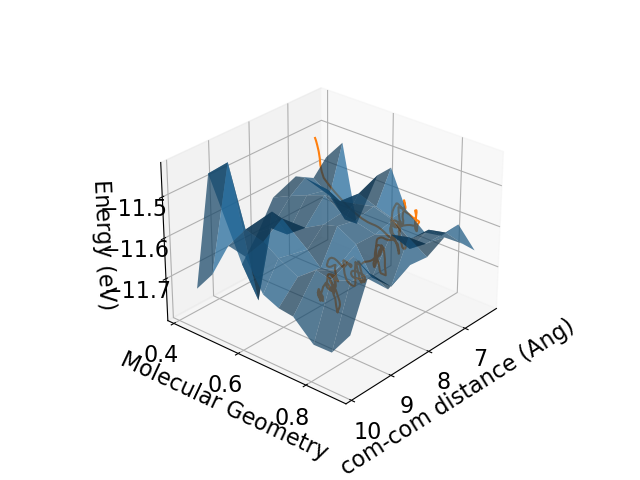

Text(0.5, 0, 'Energy (eV)')

In [7]:
%matplotlib notebook
plt.rcParams.update({'font.size': 16})
ax = plt.axes(projection='3d')
#ax.plot3D(bond_dist[0,:], mol_geo[0,:,1], U_nathf[0,:]+U_thfthf[0,:]+U_nana[0,:], 'C0')
# for i in np.arange(0,3):
#     ax.plot3D(com_dist[i,:], mol_geo[i,:,1], U_nathf[i,:]+U_thfthf[i,:]+U_nana[i,:], 'C'+str(i))
# ax.plot3D(avg_com_dist, avg_mol_geo[:,1], avg_U_nathf+avg_U_thfthf+avg_U_nana, 'gray')
# ax.plot3D(avg_bond_dist, avg_mol_geo[:,0], avg_U_nathf+avg_U_thfthf+avg_U_nana, 'C0')
ax.plot3D(avg_com_dist[:], (avg_mol_geo[:,1]+avg_mol_geo[:,0])/2, avg_U_quant[:]+avg_U_nana[:]+avg_U_nathf[:]+avg_U_thfthf[:], 'C1')
# ax.plot_wireframe(binned2d_U_nana[:,:,0], binned2d_U_nana[:,:,1], binned2d_U_quant[:,:,2], color='gray')
ax.plot_surface(binned2d_U_nathf[:,:,0], binned2d_U_nathf[:,:,1], binned2d_U_nathf[:,:,2]+
                  binned2d_U_thfthf[:,:,2]+binned2d_U_nana[:,:,2]+binned2d_U_quant[:,:,2], rstride=1, cstride=1, alpha=0.7)
# ax.contour3D(binned2d_U_nathf[:,:,0], binned2d_U_nathf[:,:,1],binned2d_U_nana[:,:,2]+
#                   binned2d_U_quant[:,:,2]+binned2d_U_nathf[:,:,2]+binned2d_U_thfthf[:,:,2], 50)
ax.set_xlabel('com-com distance (Ang)')
ax.set_ylabel('Molecular Geometry')
ax.set_zlabel('Energy (eV)')

In [ ]:
plt.savefig('Na2+_THF_cluster/55/figs/energy_surf.eps', format='eps')